# Digit Recognition

## 1 Предобработка данных

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# Параметры
LEARNING_RATE = 1e-4

TRAINING_ITERATIONS = 20000        
    
DROPOUT = 0.5

BATCH_SIZE = 50

VALIDATION_SIZE = 2000

IMAGE_TO_DISPLAY = 10

In [2]:
data = pd.read_csv('./train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [3]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# Нормализация
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [4]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


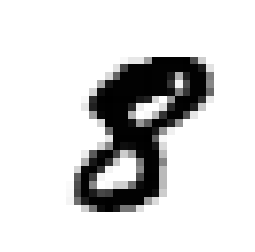

In [5]:
# Пример изображения 
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

     
display(images[IMAGE_TO_DISPLAY])

In [6]:
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


In [7]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [8]:
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [9]:
# Разделение на выборки на обучающую и валидационную
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


## 2 Определение архитектуры нейронной сети

2 Сверточных слоя с 32-мя и 64-мя фильтрами соответственно, 2 полносвязанных слоя, размером с output-ом 1024 и 10 соответсвенно. После каждой свертки выполняется операция субдискретизации (уменьшениия размерности в 2 раза).

### Вспомогательные функции для создания новых TensorFlow переменных

In [10]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Вспомогательные функции для создания новых сверточных слоев

In [11]:
def conv2d(x, W):
    return tf.nn.conv2d(x, # Предыдущий слой (входные данные)
                        W, # Веса
                        strides=[1, 1, 1, 1], # Шаг для ImageID, X, Y, input-chanenl 
                        padding='SAME') # size(Input) = size(Output)

In [12]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [13]:
# Входные и выходные данные для НС

# Изображение
x = tf.placeholder('float', shape=[None, image_size])
# Класс
y_ = tf.placeholder('float', shape=[None, labels_count])

### Первый сверточный слой

In [14]:
# Первый сверточный слой
W_conv1 = weight_variable([5, 5, 1, 32]) # filter height, filter width, number of input channels, number of filters.  
b_conv1 = bias_variable([32]) # One bias for each filter

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1) # Add biases to the result of convolution
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

### Второй сверточный слой

In [15]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

### Первый полносвязанный слой

In [16]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

Поскольку полносвязный слой подвержен переобучению, для предотвращеня этой проблемы будем использовать метод dropout, который с вероятностью 1 - keep_prob будет "выбрасывать" из сети ноды.

In [17]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Второй (финальный) полносвязанный слой

Второй полносвязный слой оценивает насколько входное изображение подходит под каждый из 10 классов. Перед этим мы нормализуем результат таким образо, что значения в выходном векторе находятся в диапазоне от 0 до 1 и в сумме дают 1 

In [18]:
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

predict = tf.argmax(y,1)

### Функция потерь

Для измерения качества модели мы должны оценивать ошибку сравнивая прогнозные и реальные значения. Перекрёстная энтропия -функция, которая принимает только неотрицательные значения и равна 0 в случае совпадения прогноза и реальности. Следовательно, целью оптимизации является минимизация перекрёстной энтропии.

In [19]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# Аналог градиентного спуска
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

### Оценка точности

Конвертим boolean в float  и находим среднее значение

In [20]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

### Функция разбиения выборки на пачки

Оптимальным вариантом было бы использование всего датасета на каждой итерации обучения, однако это слишком ресурсоемко. Вместо этого будем использовать маленькие случайные "пачки" данных. Этот метод называется стохастическое обучение.

In [21]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

## 3 Тренировка сети

Открытие TensorFlow сессии

In [22]:
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [23]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.16 / 0.12 for step 0
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 1
training_accuracy / validation_accuracy => 0.18 / 0.16 for step 2
training_accuracy / validation_accuracy => 0.14 / 0.18 for step 3
training_accuracy / validation_accuracy => 0.20 / 0.14 for step 4
training_accuracy / validation_accuracy => 0.20 / 0.24 for step 5
training_accuracy / validation_accuracy => 0.32 / 0.26 for step 6
training_accuracy / validation_accuracy => 0.38 / 0.28 for step 7
training_accuracy / validation_accuracy => 0.18 / 0.28 for step 8
training_accuracy / validation_accuracy => 0.28 / 0.30 for step 9
training_accuracy / validation_accuracy => 0.24 / 0.28 for step 10
training_accuracy / validation_accuracy => 0.46 / 0.58 for step 20
training_accuracy / validation_accuracy => 0.52 / 0.56 for step 30
training_accuracy / validation_accuracy => 0.78 / 0.74 for step 40
training_accuracy / validation_accuracy => 0.66 / 0.78 for step 50
train

Визуализируем точность

validation_accuracy => 0.9950


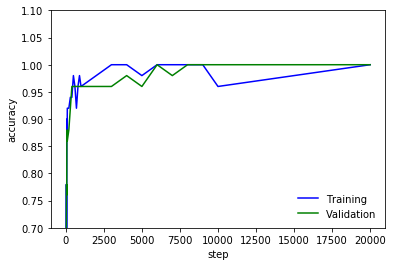

In [24]:

if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

## 4 Отработка модели на тестовых данных

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


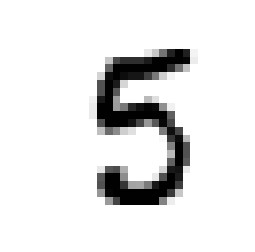

In [25]:
test_images = pd.read_csv('./test.csv').values
test_images = test_images.astype(np.float)

# нормализация
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))


display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# Сохранение результата
np.savetxt('submission.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')